In [16]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from utils import general_utils

### Analysis: compare PPLs between fwd and rev trained GPT-2s on neuroscience Train and val set
* Added the previously trained (non-bayes) GPT-2s models for reference.
* Metrics: T-test, cohen's d and Jenson Shannon Divergence (JSD).

In [29]:
# Bayes fwd and rev models
# (train-sampled and validation sets)
fwd_bayes_train_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/all_batches_ppl_train.npy"
rev_bayes_train_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/all_batches_ppl_train.npy"
fwd_bayes_val_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/all_batches_ppl_validation.npy"
rev_bayes_val_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/all_batches_ppl_validation.npy"

fwd_bayes_train_ppls = np.load(fwd_bayes_train_path)
rev_bayes_train_ppls = np.load(rev_bayes_train_path)
fwd_bayes_val_ppls = np.load(fwd_bayes_val_path)
rev_bayes_val_ppls = np.load(rev_bayes_val_path)

# Original fwd and bwd models 
# (validation set only)
fwd_path = "model_results/gpt2_scratch_neuro_tokenizer/human_abstracts/all_batches_ppl_validation.npy"
bwd_path = "model_results/gpt2_scratch_neuro_tokenizer_backwards/human_abstracts/all_batches_ppl_validation.npy"

fwd_val_ppls = np.load(fwd_path)
bwd_val_ppls = np.load(bwd_path)

In [28]:
def cohens_d_ind(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    diff_mean = np.mean(x) - np.mean(y)
    pooled_var = ((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof
    return np.abs(diff_mean / np.sqrt(pooled_var))

def cohens_d_rel(x, y):
    diff_mean = np.mean(x) - np.mean(y)
    diff_var = np.var(x - y, ddof=1)
    return np.abs(diff_mean / np.sqrt(diff_var))

### T-test

* Massive difference between paired vs independent t stats
* Paired should be the right thing to do

In [26]:
print("Bayes Val", stats.ttest_rel(fwd_bayes_val_ppls, rev_bayes_val_ppls))
print("Bayes Train", stats.ttest_rel(fwd_bayes_train_ppls, rev_bayes_train_ppls))

Bayes Val TtestResult(statistic=-15.672598361144663, pvalue=1.139724125552024e-54, df=9412)
Bayes Train TtestResult(statistic=-17.7316547078725, pvalue=8.226932024452419e-70, df=19904)


* Recall the previous fwd vs bwd models do not have exactly the same val sample sizes due to retrained tokenizer and padding; hence paired is not allowed.

In [27]:
print("Val (ind)", stats.ttest_ind(fwd_val_ppls, bwd_val_ppls))

Val (ind) TtestResult(statistic=-6.100744173422656, pvalue=1.0764487287906804e-09, df=18767.0)


In [30]:
print("Bayes Val Cohen's d", cohens_d_rel(fwd_bayes_val_ppls, rev_bayes_val_ppls))
print("Bayes Train Cohen's d", cohens_d_rel(fwd_bayes_train_ppls, rev_bayes_train_ppls))
print("Val Cohen's d (ind)", cohens_d_ind(fwd_val_ppls, bwd_val_ppls))

Bayes Val Cohen's d 0.16153884553828604
Bayes Train Cohen's d 0.12568057953519957
Val Cohen's d (ind) 0.08906221471659419


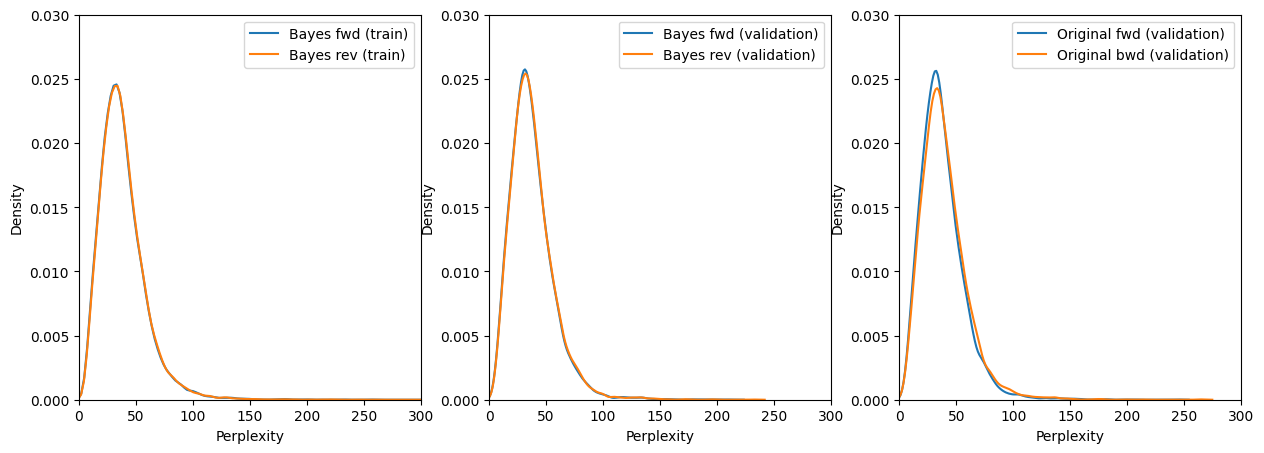

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(fwd_bayes_train_ppls, label="Bayes fwd (train)", ax=axes[0])
sns.kdeplot(rev_bayes_train_ppls, label="Bayes rev (train)", ax=axes[0])
sns.kdeplot(fwd_bayes_val_ppls, label="Bayes fwd (validation)", ax=axes[1])
sns.kdeplot(rev_bayes_val_ppls, label="Bayes rev (validation)", ax=axes[1])
sns.kdeplot(fwd_val_ppls, label="Original fwd (validation)", ax=axes[2])
sns.kdeplot(bwd_val_ppls, label="Original bwd (validation)", ax=axes[2])
axes[0].set_xlabel("Perplexity")
axes[0].legend()
axes[0].set_xlim(0, 300)
axes[0].set_ylim(0, 0.03)
axes[1].set_xlabel("Perplexity")
axes[1].legend()
axes[1].set_xlim(0, 300)
axes[1].set_ylim(0, 0.03)
axes[2].set_xlabel("Perplexity")
axes[2].set_xlim(0, 300)
axes[2].set_ylim(0, 0.03)
axes[2].legend()
plt.show()

### JSD
* Alternative to t-test, free of sample size difference problem.

In [10]:
print(
    "JSD, bayes, train", distance.jensenshannon(fwd_bayes_train_ppls, rev_bayes_train_ppls)
)

print(
    "JSD, bayes, val", distance.jensenshannon(fwd_bayes_val_ppls, rev_bayes_val_ppls)
)

print(
    "JSD, val", distance.jensenshannon(fwd_val_ppls, bwd_val_ppls)
)

JSD, bayes, train 0.015957367272225492
JSD, bayes, val 0.015864806144053237
JSD, val 0.22527979740208717


### Analysis: compare PPLs between fwd and rev trained GPT-2s on Brainbench items

### Conclusions:
* Both T-test and cohen's d suggest bayes-trained models show smaller ppl-diff for original and altered items. 
* For bayes-trained models, difference between fwd and rev models is small (effec size < 0.2)
* In terms of JSD, bayes-trained and originally trained show comparable ppl-diff for original and altered items; but overall JSD is small.

In [4]:
def _ppl_original_ppl_altered_and_ppl_diff(PPL_A_and_B, labels):
    """
    Args:
        PPL_A_and_B: (N, 2) array of PPL values for A and B
        labels: (N, ) array of labels (0 or 1) where 0 indicates A correct, B incorrect

    Returns:
        PPL_original: (N, ) array of PPL values of original/correct options
        PPL_altered: (N, ) array of PPL values of altered/incorrect options
        PPL_diff: (N, ) array of PPL difference between altered and original options
    """
    PPL_A = PPL_A_and_B[:, 0]
    PPL_B = PPL_A_and_B[:, 1]
    PPL_original = []
    PPL_altered = []
    PPL_diff = []  # altered - original
    for i, label in enumerate(labels):
        if label == 0:  # A correct, B incorrect
            PPL_original.append(PPL_A[i])
            PPL_altered.append(PPL_B[i])
            PPL_diff.append(PPL_B[i] - PPL_A[i])
        else:
            PPL_original.append(PPL_B[i])
            PPL_altered.append(PPL_A[i])
            PPL_diff.append(PPL_A[i] - PPL_B[i])
    return np.array(PPL_original), np.array(PPL_altered), np.array(PPL_diff)

def _per_item_correctness(PPL_A_and_B, labels):
    """
    Args:
        PPL_A_and_B: (N, 2) array of PPL values for A and B
        labels: (N, ) array of labels (0 or 1) where 0 indicates A correct, B incorrect

    Returns:
        correctness: (N, ) array of correctness values (1 if correct, 0 if incorrect)
    """
    correctness = []
    PPL_A = PPL_A_and_B[:, 0]
    PPL_B = PPL_A_and_B[:, 1]
    for i, label in enumerate(labels):
        if label == 0:  # A correct, B incorrect
            correctness.append(1 if PPL_A[i] < PPL_B[i] else 0)
        else:
            correctness.append(1 if PPL_B[i] < PPL_A[i] else 0)
    return np.array(correctness)

In [5]:
general_utils.scorer_acc

<function utils.general_utils.scorer_acc(PPL_A_and_B, labels)>

In [6]:
# Bayes fwd and rev models
fwd_bayes_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/PPL_A_and_B.npy"
fwd_bayes_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/labels.npy"
rev_bayes_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/PPL_A_and_B.npy"
rev_bayes_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/labels.npy"

fwd_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer/human_abstracts/PPL_A_and_B.npy"
fwd_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer/human_abstracts/labels.npy"
bwd_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_backwards/human_abstracts/PPL_A_and_B.npy"
bwd_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_backwards/human_abstracts/labels.npy"

fwd_bayes_brainbench_ppls = np.load(fwd_bayes_brainbench_ppls_path)
fwd_bayes_brainbench_labels = np.load(fwd_bayes_brainbench_labels_path)
rev_bayes_brainbench_ppls = np.load(rev_bayes_brainbench_ppls_path)
rev_bayes_brainbench_labels = np.load(rev_bayes_brainbench_labels_path)

# Original fwd and bwd models
fwd_brainbench_ppls = np.load(fwd_brainbench_ppls_path)
fwd_brainbench_labels = np.load(fwd_brainbench_labels_path)
bwd_brainbench_ppls = np.load(bwd_brainbench_ppls_path)
bwd_brainbench_labels = np.load(bwd_brainbench_labels_path)

fwd_bayes_brainbench_ppls_original, fwd_bayes_brainbench_ppls_altered, fwd_bayes_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)

fwd_brainbench_ppls_original, fwd_brainbench_ppls_altered, fwd_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(fwd_brainbench_ppls, fwd_brainbench_labels)
bwd_brainbench_ppls_original, bwd_brainbench_ppls_altered, bwd_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(bwd_brainbench_ppls, bwd_brainbench_labels)

print(fwd_bayes_brainbench_ppls_original.shape, fwd_bayes_brainbench_ppls_diff.shape)
print(rev_bayes_brainbench_ppls_original.shape, rev_bayes_brainbench_ppls_diff.shape)


(200,) (200,)
(200,) (200,)


In [7]:
# Get acc
fwd_bayes_brainbench_acc = general_utils.scorer_acc(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_acc = general_utils.scorer_acc(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
fwd_brainbench_acc = general_utils.scorer_acc(fwd_brainbench_ppls, fwd_brainbench_labels)
bwd_brainbench_acc = general_utils.scorer_acc(bwd_brainbench_ppls, bwd_brainbench_labels)
print("Bayes fwd brainbench acc", fwd_bayes_brainbench_acc)
print("Bayes rev brainbench acc", rev_bayes_brainbench_acc)
print("Fwd brainbench acc", fwd_brainbench_acc)
print("Bwd brainbench acc", bwd_brainbench_acc)

# Sanity check acc
print('\nSanity check acc')
print("Bayes fwd brainbench acc", np.mean(_per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)))
print("Bayes rev brainbench acc", np.mean(_per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)))
print("Fwd brainbench acc", np.mean(_per_item_correctness(fwd_brainbench_ppls, fwd_brainbench_labels)))
print("Bwd brainbench acc", np.mean(_per_item_correctness(bwd_brainbench_ppls, bwd_brainbench_labels)))

Bayes fwd brainbench acc 0.605
Bayes rev brainbench acc 0.64
Fwd brainbench acc 0.625
Bwd brainbench acc 0.64

Sanity check acc
Bayes fwd brainbench acc 0.605
Bayes rev brainbench acc 0.64
Fwd brainbench acc 0.625
Bwd brainbench acc 0.64


In [41]:
# T-test (ppl original)
print(
    "Bayes Brainbench",
    stats.ttest_rel(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original),
)

print(
    "Brainbench",
    stats.ttest_rel(fwd_brainbench_ppls_original, bwd_brainbench_ppls_original),
)

Bayes Brainbench TtestResult(statistic=2.117760377137123, pvalue=0.03543670106655037, df=199)
Brainbench TtestResult(statistic=-9.36798335477271, pvalue=1.6490264300274633e-17, df=199)


In [42]:
# T-test (ppl altered)
print(
    "Bayes Brainbench",
    stats.ttest_rel(fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered),
)

print(
    "Brainbench",
    stats.ttest_rel(fwd_brainbench_ppls_altered, bwd_brainbench_ppls_altered),
)

Bayes Brainbench TtestResult(statistic=1.9212736465551556, pvalue=0.056126111455141986, df=199)
Brainbench TtestResult(statistic=-9.124224120120754, pvalue=8.121712652679595e-17, df=199)


In [43]:
# T-test (ppl diff)
print(
    "Bayes Brainbench",
    stats.ttest_rel(fwd_bayes_brainbench_ppls_diff, rev_bayes_brainbench_ppls_diff),
)
print(
    "Brainbench",
    stats.ttest_rel(fwd_brainbench_ppls_diff, bwd_brainbench_ppls_diff),
)

Bayes Brainbench TtestResult(statistic=-0.8480519914921127, pvalue=0.397427891551025, df=199)
Brainbench TtestResult(statistic=0.3110397595151271, pvalue=0.7560959664791471, df=199)


In [ ]:
# Cohens' d (ppl original)
print(
    "Bayes Brainbench Cohen's d",
    cohens_d_rel(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original),
)

print(
    "Original Brainbench Cohen's d",
    cohens_d_rel(fwd_brainbench_ppls_orginal, bwd_brainbench_ppls_correct_original),
)

Bayes Brainbench Cohen's d 0.14974827236018215
Original Brainbench Cohen's d 0.6624164556202489


In [45]:
# Cohens' d (ppl altered)
print(
    "Bayes Brainbench Cohen's d",
    cohens_d_rel(fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered),
)

print(
    "Original Brainbench Cohen's d",
    cohens_d_rel(fwd_brainbench_ppls_altered, bwd_brainbench_ppls_altered),
)

Bayes Brainbench Cohen's d 0.1358545623994156
Original Brainbench Cohen's d 0.6451800748403246


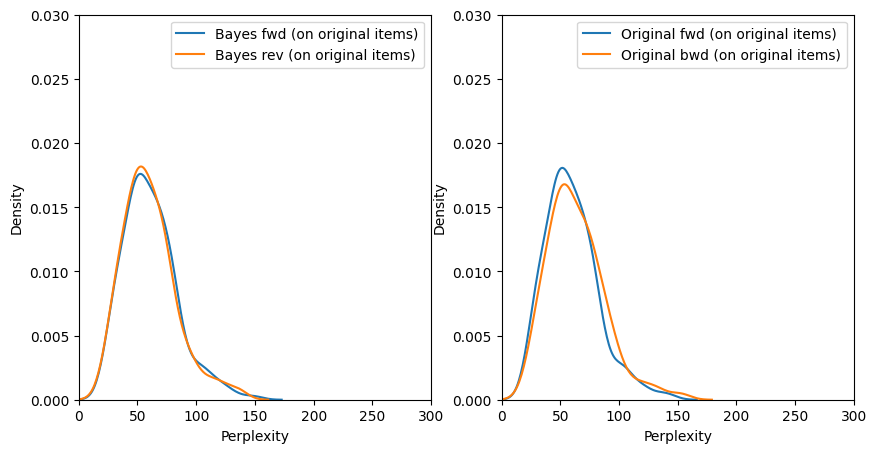

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(fwd_bayes_brainbench_ppls_original, label="Bayes fwd (on original items)", ax=axes[0])
sns.kdeplot(rev_bayes_brainbench_ppls_original, label="Bayes rev (on original items)", ax=axes[0])
sns.kdeplot(fwd_brainbench_ppls_original, label="Original fwd (on original items)", ax=axes[1])
sns.kdeplot(bwd_brainbench_ppls_original, label="Original bwd (on original items)", ax=axes[1])
axes[0].set_xlabel("Perplexity")
axes[0].legend()
axes[0].set_xlim(0, 300)
axes[0].set_ylim(0, 0.03)
axes[1].set_xlabel("Perplexity")
axes[1].set_xlim(0, 300)
axes[1].set_ylim(0, 0.03)
axes[1].legend()
plt.show()

In [48]:
# JSD (ppl original)
print(
    "JSD, Bayes, Brainbench",
    distance.jensenshannon(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original),
)

print(
    "JSD, Brainbench",
    distance.jensenshannon(fwd_brainbench_ppls_original, bwd_brainbench_ppls_original),
)

JSD, Bayes, Brainbench 0.026120063057237883
JSD, Brainbench 0.029840276818802282


### Aanalysis: BrainBench performance vs item fwd & rev ppl diff
* This is to examine whether magnitude of discrepency in PPL of the same item processed by fwd and rev trained models (i.e., fwd-rev ppl-diff) correlates with that item's BrainBench accuracy (both in terms of altered-original ppl-diff as continuous accuracy and binary outcome)
    - Plot 1: For a given model (fwd or rev), we compare if a smaller fwd-rev ppl-diff indicates higher altered-original ppl-diff (continuous) by fitting a linear regression.
    - Plot 2: For a given model (fwd or rev), we compare if a smaller fwd-rev ppl-diff indicates correctness (binary) by fitting a linear regression.
    - Plot 3: Same analysis as 2 but plot by grouping `fwd-rev ppl-diff` based on correctness and compare distributional difference.
* Q: Do we care about fwd-rev ppl-diff direction or not?
    - One opinion is direction does not matter because we have no idea which direction SHOULD have lower ppl. It is more about how much they diff in abs.
* Q: When we use `magnitude of discrepency in PPL of the same item`, should we be using the original or the altered? - No idea whichever choice can be clearly justified.

In [10]:
fwd_rev_bayes_brainbench_original_ppl_diff \
    = np.abs(fwd_bayes_brainbench_ppls_original - rev_bayes_brainbench_ppls_original)
fwd_rev_bayes_brainbench_altered_ppl_diff \
    = np.abs(fwd_bayes_brainbench_ppls_altered - rev_bayes_brainbench_ppls_altered)


Bayes Fwd model (x-axis: Brainbench original)
--------------------
Slope: 0.007548002910054507
Intercept: 0.24189749608178196
R-squared: 0.0002887987751137303
P-value: 0.8112269954072153

Bayes Rev model (x-axis: Brainbench original)
--------------------
Slope: 0.003984455769822818
Intercept: 0.3237716726929212
R-squared: 7.849775870367381e-05
P-value: 0.9009075862659366

Bayes Fwd model (x-axis: Brainbench altered)
--------------------
Slope: 0.06059702226912768
Intercept: 0.05367608203377741
R-squared: 0.018127357285725815
P-value: 0.057328735928530716

Bayes Rev model (x-axis: Brainbench altered)
--------------------
Slope: 0.004073298666781223
Intercept: 0.323427597500508
R-squared: 7.989368355136223e-05
P-value: 0.9000349385026619


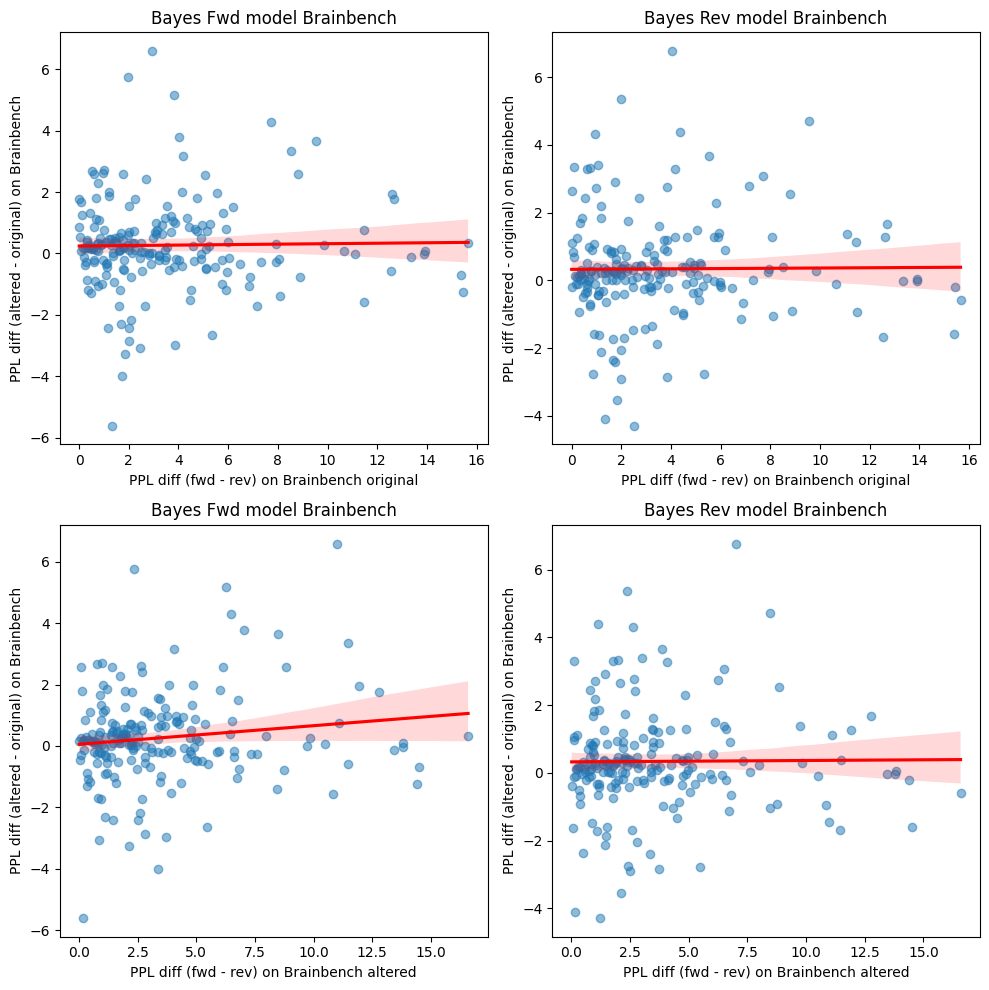

In [50]:
### Plot 1:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench (x-axis: Brainbench original)
axes[0].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff,
    fwd_bayes_brainbench_ppls_diff,
    alpha=0.5,
)
axes[0].set_xlabel("PPL diff (fwd - rev) on Brainbench original")
axes[0].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[0].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff,
    y=fwd_bayes_brainbench_ppls_diff,
    ax=axes[0],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff, fwd_bayes_brainbench_ppls_diff
)
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 1: Bayes Rev model Brainbench (x-axis: Brainbench original)
axes[1].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff,
    rev_bayes_brainbench_ppls_diff,
    alpha=0.5,
)
axes[1].set_xlabel("PPL diff (fwd - rev) on Brainbench original")
axes[1].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[1].set_title("Bayes Rev model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff,
    y=rev_bayes_brainbench_ppls_diff,
    ax=axes[1],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff, rev_bayes_brainbench_ppls_diff
)
print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)


# subplot 2: Bayes Fwd model Brainbench (x-axis: Brainbench altered)
axes[2].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff,
    fwd_bayes_brainbench_ppls_diff,
    alpha=0.5,
)
axes[2].set_xlabel("PPL diff (fwd - rev) on Brainbench altered")
axes[2].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[2].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff,
    y=fwd_bayes_brainbench_ppls_diff,
    ax=axes[2],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff, fwd_bayes_brainbench_ppls_diff
)
print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 3: Bayes Rev model Brainbench (x-axis: Brainbench altered)
axes[3].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff,
    rev_bayes_brainbench_ppls_diff,
    alpha=0.5,
)
axes[3].set_xlabel("PPL diff (fwd - rev) on Brainbench altered")
axes[3].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[3].set_title("Bayes Rev model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff,
    y=rev_bayes_brainbench_ppls_diff,
    ax=axes[3],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff, rev_bayes_brainbench_ppls_diff
)
print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

plt.tight_layout()
plt.show()

Fwd Bayes acc = 0.605
Rev Bayes acc = 0.64

Bayes Fwd model (x-axis: Brainbench original)
--------------------
Slope: -0.021673248461179427
Intercept: 0.6817182562518147
R-squared: 0.022126143362417194
P-value: 0.035540480896045466

Bayes Rev model (x-axis: Brainbench original)
--------------------
Slope: -0.01714450968733375
Intercept: 0.7006875748165079
R-squared: 0.014360773637464222
P-value: 0.0909864669587052

Bayes Fwd model (x-axis: Brainbench altered)
--------------------
Slope: -0.01199961926459067
Intercept: 0.6475630356695263
R-squared: 0.006605311969382775
P-value: 0.25259705147378825

Bayes Rev model (x-axis: Brainbench altered)
--------------------
Slope: -0.02039678530366144
Intercept: 0.7123480538241084
R-squared: 0.019794833161018814
P-value: 0.0469070085826461


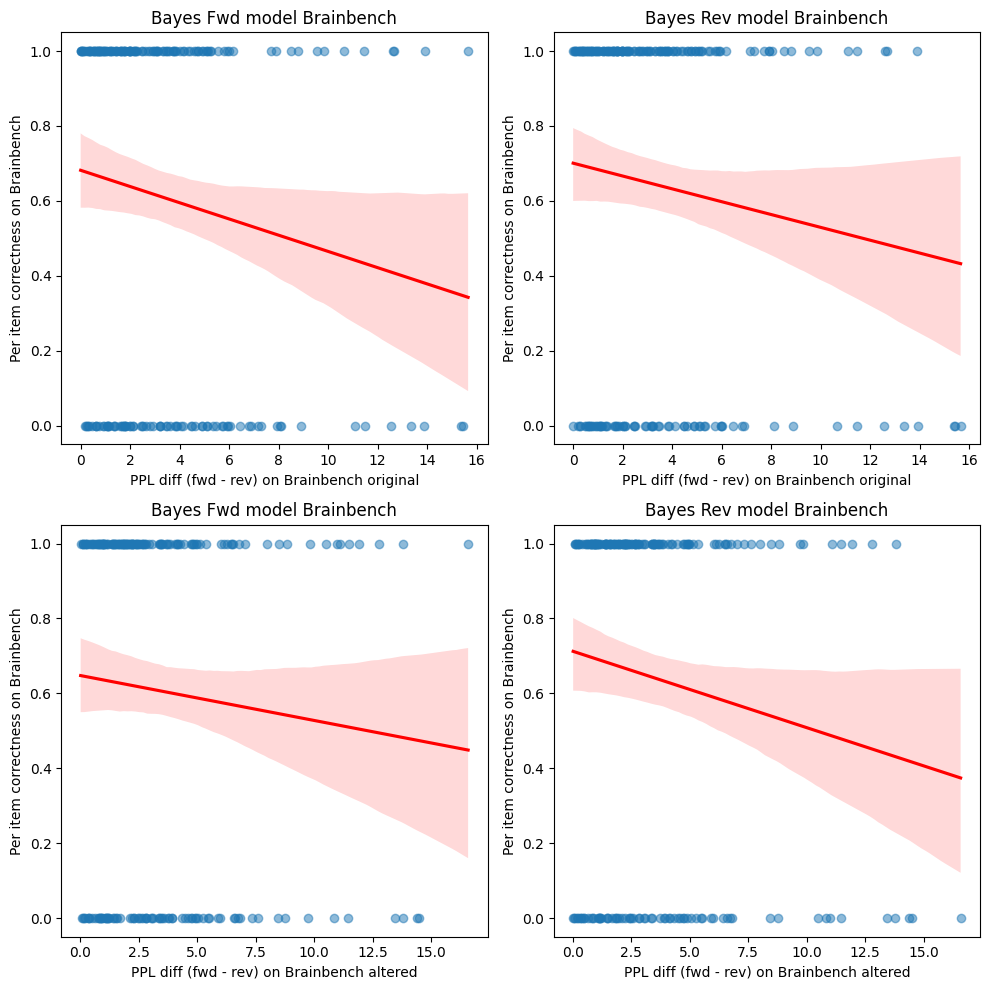

In [51]:
### Plot 2:
fwd_bayes_brainbench_per_item_correctness = _per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_per_item_correctness = _per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
print(f"Fwd Bayes acc = {np.mean(fwd_bayes_brainbench_per_item_correctness)}")
print(f"Rev Bayes acc = {np.mean(rev_bayes_brainbench_per_item_correctness)}")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench (x-axis: Brainbench original)
axes[0].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff,
    fwd_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)

axes[0].set_xlabel("PPL diff (fwd - rev) on Brainbench original")
axes[0].set_ylabel("Per item correctness on Brainbench")
axes[0].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff,
    y=fwd_bayes_brainbench_per_item_correctness,
    ax=axes[0],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff, fwd_bayes_brainbench_per_item_correctness
)
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 1: Bayes Rev model Brainbench (x-axis: Brainbench original)
axes[1].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff,
    rev_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[1].set_xlabel("PPL diff (fwd - rev) on Brainbench original")
axes[1].set_ylabel("Per item correctness on Brainbench")
axes[1].set_title("Bayes Rev model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff,
    y=rev_bayes_brainbench_per_item_correctness,
    ax=axes[1],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff, rev_bayes_brainbench_per_item_correctness
)
print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 2: Bayes Fwd model Brainbench (x-axis: Brainbench altered)
axes[2].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff,
    fwd_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[2].set_xlabel("PPL diff (fwd - rev) on Brainbench altered")
axes[2].set_ylabel("Per item correctness on Brainbench")
axes[2].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff,
    y=fwd_bayes_brainbench_per_item_correctness,
    ax=axes[2],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff, fwd_bayes_brainbench_per_item_correctness
)
print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 3: Bayes Rev model Brainbench (x-axis: Brainbench altered)
axes[3].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff,
    rev_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[3].set_xlabel("PPL diff (fwd - rev) on Brainbench altered")
axes[3].set_ylabel("Per item correctness on Brainbench")
axes[3].set_title("Bayes Rev model Brainbench")
# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff,
    y=rev_bayes_brainbench_per_item_correctness,
    ax=axes[3],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff, rev_bayes_brainbench_per_item_correctness
)
print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

plt.tight_layout()
plt.show()

In [17]:
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_original_ppl_diff
y = fwd_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_original_ppl_diff
y = rev_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_altered_ppl_diff
y = fwd_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_altered_ppl_diff
y = rev_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())


Bayes Fwd model (x-axis: Brainbench original)
--------------------
Optimization terminated successfully.
         Current function value: 0.660023
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                 0.01626
Time:                        14:10:19   Log-Likelihood:                -132.00
converged:                       True   LL-Null:                       -134.19
Covariance Type:            nonrobust   LLR p-value:                   0.03671
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7499      0.215      3.

In [8]:
fwd_bayes_brainbench_per_item_correctness = _per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_per_item_correctness = _per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
print(f"Fwd Bayes acc = {np.mean(fwd_bayes_brainbench_per_item_correctness)}")
print(f"Rev Bayes acc = {np.mean(rev_bayes_brainbench_per_item_correctness)}")

Fwd Bayes acc = 0.605
Rev Bayes acc = 0.64


Fwd Bayes acc = 0.605
Rev Bayes acc = 0.64
Bayes Brainbench fwd model (original items) TtestResult(statistic=-2.116625570294052, pvalue=0.035540480896045466, df=198.0)
Bayes Brainbench rev model (original items) TtestResult(statistic=-1.6984881603407795, pvalue=0.0909864669587052, df=198.0)
Bayes Brainbench fwd model (altered items) TtestResult(statistic=-1.1474092469859227, pvalue=0.2525970514737886, df=198.0)
Bayes Brainbench rev model (altered items) TtestResult(statistic=-1.999631751993019, pvalue=0.0469070085826461, df=198.0)


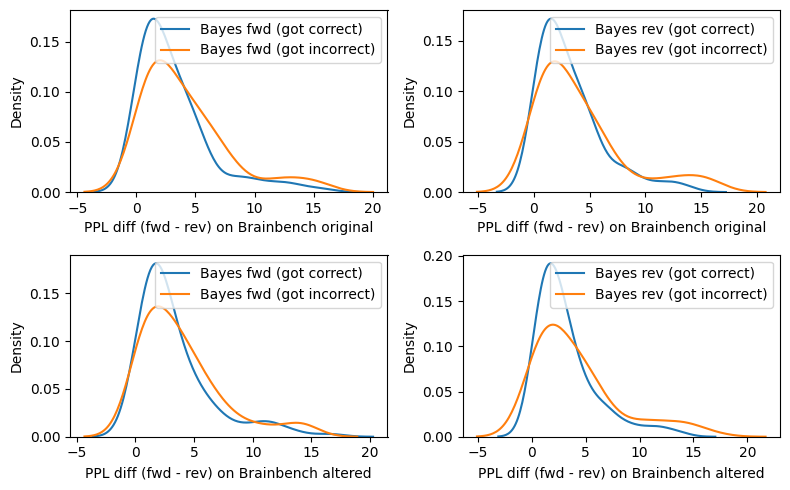

In [ ]:
### Plot 3:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench
# two distributions are: 
# i) ppl-diff between fwd and rev models for original brainbench items the fwd model got correct
# ii) ppl-diff between fwd and rev models for original brainbench items the fwd model got incorrect
fwd_rev_bayes_brainbench_original_ppl_diff_correct = fwd_rev_bayes_brainbench_original_ppl_diff[
    fwd_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_original_ppl_diff_incorrect = fwd_rev_bayes_brainbench_original_ppl_diff[
    fwd_bayes_brainbench_per_item_correctness == 0
]

sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_correct,
    label="Bayes fwd (got correct)",
    ax=axes[0],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_incorrect,
    label="Bayes fwd (got incorrect)",
    ax=axes[0],
)
axes[0].set_xlabel("PPL diff (fwd - rev) on Brainbench original")
axes[0].legend()

# T-test
print(
    "Bayes Brainbench fwd model (original items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_original_ppl_diff_correct,
        fwd_rev_bayes_brainbench_original_ppl_diff_incorrect,
    ),
)

# subplot 1: Bayes Rev model Brainbench
# two distributions are:
# i) ppl-diff between fwd and rev models for original brainbench items the rev model got correct
# ii) ppl-diff between fwd and rev models for original brainbench items the rev model got incorrect
fwd_rev_bayes_brainbench_original_ppl_diff_correct = fwd_rev_bayes_brainbench_original_ppl_diff[
    rev_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_original_ppl_diff_incorrect = fwd_rev_bayes_brainbench_original_ppl_diff[
    rev_bayes_brainbench_per_item_correctness == 0
]

sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_correct,
    label="Bayes rev (got correct)",
    ax=axes[1],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_incorrect,
    label="Bayes rev (got incorrect)",
    ax=axes[1],
)
axes[1].set_xlabel("PPL diff (fwd - rev) on Brainbench original")
axes[1].legend()

# T-test
print(
    "Bayes Brainbench rev model (original items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_original_ppl_diff_correct,
        fwd_rev_bayes_brainbench_original_ppl_diff_incorrect,
    ),
)

# subplot 2: Bayes Fwd model Brainbench
# two distributions are:
# i) ppl-diff between fwd and rev models for altered brainbench items the fwd model got correct
# ii) ppl-diff between fwd and rev models for altered brainbench items the fwd model got incorrect
fwd_rev_bayes_brainbench_altered_ppl_diff_correct = fwd_rev_bayes_brainbench_altered_ppl_diff[
    fwd_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_altered_ppl_diff_incorrect = fwd_rev_bayes_brainbench_altered_ppl_diff[
    fwd_bayes_brainbench_per_item_correctness == 0
]
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_correct,
    label="Bayes fwd (got correct)",
    ax=axes[2],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_incorrect,
    label="Bayes fwd (got incorrect)",
    ax=axes[2],
)
axes[2].set_xlabel("PPL diff (fwd - rev) on Brainbench altered")
axes[2].legend()

# T-test
print(
    "Bayes Brainbench fwd model (altered items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_altered_ppl_diff_correct,
        fwd_rev_bayes_brainbench_altered_ppl_diff_incorrect,
    ),
)

# subplot 3: Bayes Rev model Brainbench
# two distributions are:
# i) ppl-diff between fwd and rev models for altered brainbench items the rev model got correct
# ii) ppl-diff between fwd and rev models for altered brainbench items the rev model got incorrect
fwd_rev_bayes_brainbench_altered_ppl_diff_correct = fwd_rev_bayes_brainbench_altered_ppl_diff[
    rev_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_altered_ppl_diff_incorrect = fwd_rev_bayes_brainbench_altered_ppl_diff[
    rev_bayes_brainbench_per_item_correctness == 0
]
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_correct,
    label="Bayes rev (got correct)",
    ax=axes[3],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_incorrect,
    label="Bayes rev (got incorrect)",
    ax=axes[3],
)
axes[3].set_xlabel("PPL diff (fwd - rev) on Brainbench altered")
axes[3].legend()

# T-test
print(
    "Bayes Brainbench rev model (altered items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_altered_ppl_diff_correct,
        fwd_rev_bayes_brainbench_altered_ppl_diff_incorrect,
    ),
)

plt.tight_layout()